## Analyzing maximum sharpe ratio portfolio

Different metrics for MSR portfolio, could be used for any set of weights

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv("datasets/adi.csv", index_col="Date", parse_dates=True)

In [3]:
print(f"From: {df.index[0].strftime('%a, %b %d %Y')}\n\nTo: {df.index[-1].strftime('%a, %b %d %Y')}")

From: Thu, Jan 01 2015

To: Thu, Jul 09 2020


In [4]:
# Adjust Historical Range
df = df.loc["2018":"2020"]

In [5]:
returns = df.pct_change().dropna()
annulized_returns = (returns+1).prod()**(252/returns.shape[0])-1
annulized_volatility = returns.std()*(252**0.5)

def portfolio_return(weights, returns):
    return weights.T @ returns

def portfolio_vol(weights, covmat):
    return (weights.T @ covmat @ weights)**0.5

In [6]:
# Maximum Sharpe Ratio
from scipy.optimize import minimize

def max_sharp_ratio(returns, cov, riskfree_rate = 0.07):
    
    n = returns.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe(weights, riskfree_rate, returns, cov):
        r = portfolio_return(weights, returns)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol
    
    weights = minimize(neg_sharpe, 
                       init_guess,
                       args=(riskfree_rate, returns, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

In [7]:
weights = max_sharp_ratio(annulized_returns, returns.cov())

In [8]:
weights

array([0.00000000e+00, 1.66311409e-13, 1.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.37729844e-13, 4.44089210e-16])

In [9]:
returns.head()

,ATULAUTO,GOODYEAR,AXISBANK,ALCHEM,COALINDIA,NDTV,GUJALKALI
Date,,,,,,,
2018-01-02,-0.006381,-0.012700,-0.009117,-0.028245,0.014637,-0.001099,-0.011395
2018-01-03,0.008858,0.030928,0.001161,0.000000,0.007213,0.014301,0.004271
2018-01-04,-0.002305,0.071441,-0.001874,0.015225,0.020198,0.010846,0.024102
2018-01-05,-0.002860,0.034012,0.006794,-0.018405,0.003420,0.000000,0.040675
2018-01-08,-0.007502,-0.009799,0.003996,0.014583,0.032646,0.007511,0.006081


## Equity Curve

In [10]:
running_portfolio_return = pd.DataFrame()
for i in range(len(returns.columns)):
    if i == 0:
        running_portfolio_return["returns"] = (returns*weights)[returns.columns[i]]
        continue
    running_portfolio_return["returns"] += (returns*weights)[returns.columns[i]]

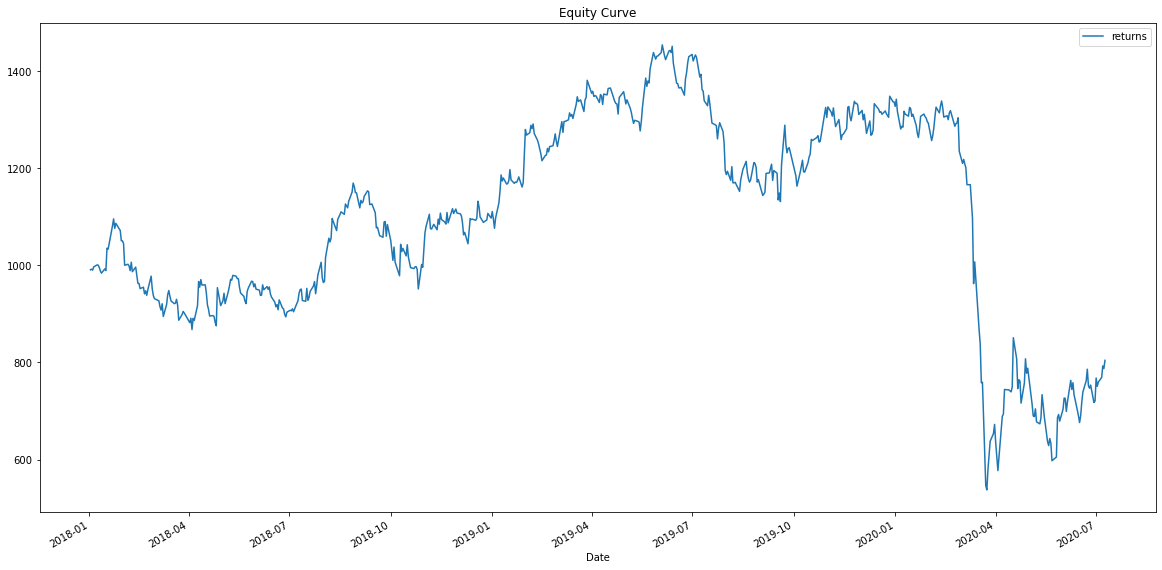

In [11]:
equity_series = (running_portfolio_return+1).cumprod()*1000
equity_series.plot(figsize=[20,10], title="Equity Curve")

## Drawdowns

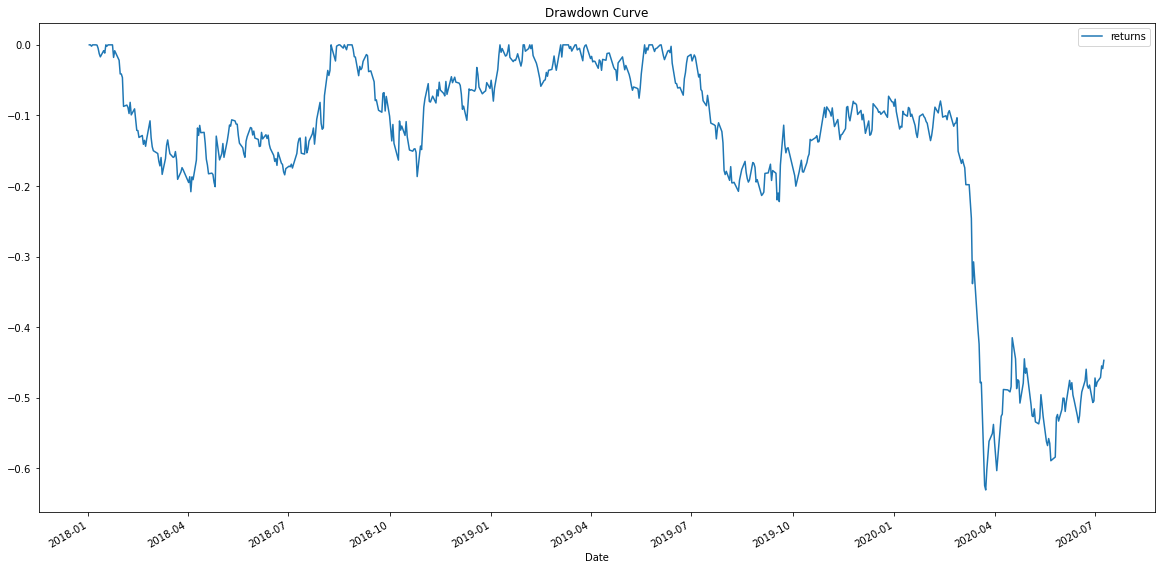

In [12]:
drawdown = (equity_series - equity_series.cummax())/equity_series.cummax()
drawdown.plot(figsize=[20,10], title="Drawdown Curve")

In [13]:
print(f"Maximum Drawdown: {np.round(drawdown.returns.min()*100, 2)}%\n\
Happened On: {drawdown.index[drawdown.returns.argmin()]}")

Maximum Drawdown: -63.05%
Happened On: 2020-03-24 00:00:00


In [20]:
semideviation = running_portfolio_return["returns"][running_portfolio_return["returns"]<0].std(ddof=0)
print(f"Semideviation: {semideviation}")

Semideviation: 0.022326617780255745
